In [1]:
import sys
import os

In [15]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score
from typing import Callable
from abc import ABC, abstractmethod
from sortedcontainers import SortedList

In [3]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [4]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [5]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [6]:
class NodeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        for i in range(n-1):
            for j in range(i+1, n):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = solution[(j-1)%n]
        j2 = solution[j%n]
        j3 = solution[(j+1)%n]
        #edge case when two consecutive nodes selected
        if i-j == -1:
            return -self.dist_mat[i1, i2] - self.dist_mat[i2, j2] - self.dist_mat[j2, j3] \
                + self.dist_mat[i1, j2] + self.dist_mat[j2, i2] + self.dist_mat[i2, j3]
        
        if i == 0 and j == n - 1:
            return -self.dist_mat[j1, j2] - self.dist_mat[j2, i2] - self.dist_mat[i2, i3] \
                + self.dist_mat[j1, i2] + self.dist_mat[i2, j2] + self.dist_mat[j2, i3]
        
        difference = -self.dist_mat[i1, i2] - self.dist_mat[i2, i3] - self.dist_mat[j1, j2] - self.dist_mat[j2, j3] \
            + self.dist_mat[i1, j2] + self.dist_mat[j2, i3] + self.dist_mat[j1, i2] + self.dist_mat[i2, j3]
        return difference
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i], solution[j] = solution[j], solution[i]
        return solution

In [7]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution


In [8]:
from typing import List


class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution

In [9]:
class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)

    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size

In [10]:
test_n = 100
test_distances = np.random.randint(0, 100, (test_n, test_n))
test_costs = np.random.randint(0, 100, (test_n, 1))
test_solution = get_random_solution(test_n)
for i in range(test_n):
    for j in range(test_n):
        if i == j:
            test_distances[i, j]=0
        else:
            test_distances[i, j] = test_distances[j, i]

test_unselected = SortedList(range(test_n))
for i in test_solution:
    test_unselected.remove(i)

print(test_distances)
print(test_costs)
print(test_solution)

[[ 0 29  5 ... 85  3 44]
 [29  0 78 ... 65 78 12]
 [ 5 78  0 ... 63 71 55]
 ...
 [85 65 63 ...  0 65 48]
 [ 3 78 71 ... 65  0 28]
 [44 12 55 ... 48 28  0]]
[[54]
 [23]
 [90]
 [11]
 [44]
 [31]
 [22]
 [ 7]
 [20]
 [ 6]
 [51]
 [35]
 [21]
 [84]
 [17]
 [96]
 [93]
 [37]
 [99]
 [45]
 [78]
 [94]
 [77]
 [99]
 [24]
 [92]
 [79]
 [88]
 [93]
 [59]
 [71]
 [42]
 [ 9]
 [94]
 [18]
 [94]
 [34]
 [35]
 [61]
 [25]
 [85]
 [ 2]
 [88]
 [16]
 [ 7]
 [77]
 [ 1]
 [43]
 [94]
 [86]
 [50]
 [10]
 [72]
 [73]
 [72]
 [48]
 [92]
 [61]
 [27]
 [82]
 [15]
 [ 6]
 [73]
 [54]
 [ 3]
 [29]
 [79]
 [37]
 [23]
 [25]
 [99]
 [10]
 [97]
 [ 2]
 [21]
 [20]
 [ 0]
 [74]
 [89]
 [76]
 [26]
 [79]
 [40]
 [34]
 [47]
 [65]
 [41]
 [55]
 [52]
 [44]
 [91]
 [75]
 [10]
 [91]
 [67]
 [ 0]
 [22]
 [64]
 [59]
 [31]]
[np.int64(44), np.int64(29), np.int64(10), np.int64(55), np.int64(47), np.int64(65), np.int64(61), np.int64(67), np.int64(43), np.int64(39), np.int64(91), np.int64(34), np.int64(31), np.int64(46), np.int64(98), np.int64(80), np.int64(86), np.i

In [11]:
def test_neighborhoods(test_solution, test_distances, test_costs, test_neighborhood):
    test_score = score(test_solution, test_distances, test_costs)

    test_objective_changes = [test_neighborhood.get_difference(i, test_solution, test_unselected)
                                for i in range(test_neighborhood.neighborhood_size())]

    test_new_solutions = [test_neighborhood.modify_solution(i, test_solution.copy(), test_unselected.copy())
                                for i in range(test_neighborhood.neighborhood_size())]

    test_scores = [score(solution, test_distances, test_costs) for solution in test_new_solutions]
    test_score_changes = [-test_score + score for score in test_scores]
    for i, j in zip(test_objective_changes, test_score_changes):
        assert i == j

In [12]:
test_neighborhoods(
    test_solution, 
    test_distances, 
    test_costs, 
    NodeNeighborhood(test_distances, test_costs, test_n // 2), 
    )

test_neighborhoods(
    test_solution, 
    test_distances, 
    test_costs, 
    EdgeNeighborhood(test_distances, test_costs, test_n // 2), 
    )

test_neighborhoods(
    test_solution, 
    test_distances, 
    test_costs, 
    InterNeighborhood(test_distances, test_costs, test_n // 2), 
    )

In [13]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        objective_changes = [neighborhood.get_difference(i, solution, unselected)
                            for i in range(neighborhood.neighborhood_size())]
        best_index = np.argmin(objective_changes)
        if objective_changes[best_index] >= 0:
            return solution
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [14]:
def greedy(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        indexes = np.arange(neighborhood.neighborhood_size())
        np.random.shuffle(indexes)
        objective_change = 1
        for i in indexes:
            objective_change = neighborhood.get_difference(i, solution, unselected)
            if objective_change < 0:
                solution = neighborhood.modify_solution(i, solution, unselected)
                break
        if objective_change >= 0:
            return solution

In [17]:
def test_method(method: Callable, neighborhood: Neighborhood, initial_random: bool, n: int, name=''):
    scores_2=[]
    sols_2=[]
    total_time = 0
    for x in range(200):
        if initial_random:
            initial_solution = get_random_solution(n)
        else:
            initial_solution = greedy_2_regret_weighted(x, dist, costs)
    
        begin_time = time.time()
        solution_2=method(initial_solution, dist, costs, neighborhood)
        total_time += (time.time() - begin_time)

        sols_2.append(solution_2)

        scores_2.append(score(solution_2, dist, costs))   

    print('scores of greedy, random, node neighborhood: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'average execution time: {total_time / 200}')
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, f'best solution for {name}')

In [18]:
n = 200
nodeNeighborhood = NodeNeighborhood(dist, costs, n // 2)
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood1 = CombinedNeighborhood([nodeNeighborhood, interNeighborhood])
neighborhood2 = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


scores of greedy, random, node neighborhood:  79177 86143.175 94071
[np.int64(143), 183, np.int64(89), np.int64(62), np.int64(49), np.int64(178), 3, np.int64(138), np.int64(14), np.int64(144), np.int64(9), np.int64(124), np.int64(94), 80, np.int64(176), np.int64(149), np.int64(131), 184, 54, np.int64(177), 112, 70, np.int64(57), 55, np.int64(52), 106, np.int64(165), 39, np.int64(27), np.int64(90), 81, np.int64(31), 56, np.int64(113), np.int64(175), np.int64(171), 16, 25, np.int64(44), np.int64(120), 101, 26, 100, 63, np.int64(79), 133, 127, np.int64(123), np.int64(65), 115, 139, np.int64(68), np.int64(108), np.int64(18), np.int64(22), np.int64(146), 159, np.int64(193), np.int64(41), 5, 42, 181, np.int64(34), np.int64(48), np.int64(160), np.int64(43), np.int64(116), 59, 118, np.int64(151), np.int64(162), 135, np.int64(154), 180, 53, 86, 75, 78, np.int64(145), np.int64(179), np.int64(196), 40, 119, 185, np.int64(92), 129, 2, 1, 97, np.int64(152), np.int64(167), 148, np.int64(15), 186, np

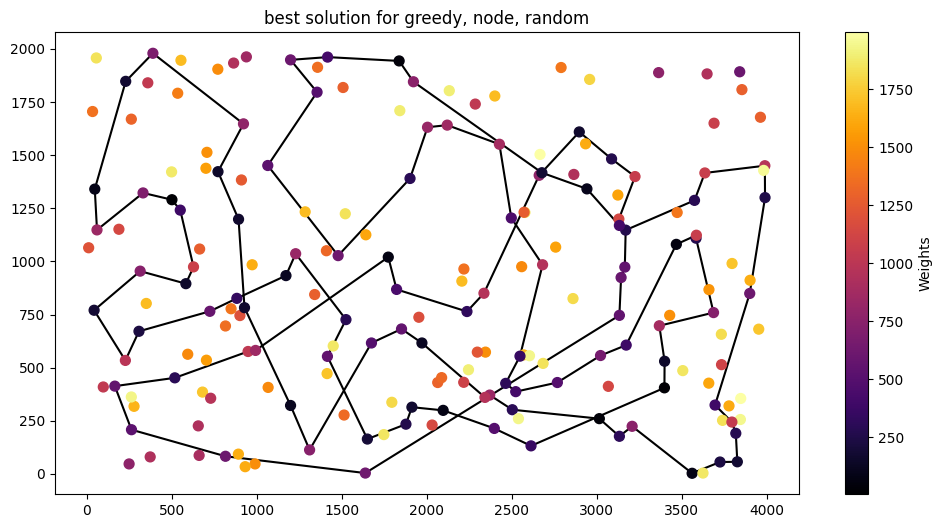

In [19]:
test_method(greedy, neighborhood1, True, 200, 'greedy, node, random')

scores of greedy, random, node neighborhood:  71313 73819.85 76632
[np.int64(185), 106, 178, 14, np.int64(144), np.int64(102), 49, np.int64(167), 148, np.int64(9), 62, 15, np.int64(186), np.int64(89), 183, np.int64(23), np.int64(137), np.int64(176), 80, 124, 94, np.int64(63), 79, 133, 162, 151, np.int64(51), np.int64(118), np.int64(59), np.int64(149), 131, np.int64(43), 65, 116, np.int64(115), 139, 46, 0, np.int64(143), 117, np.int64(93), 140, 108, 18, np.int64(22), 159, np.int64(193), np.int64(41), np.int64(5), np.int64(42), 181, np.int64(34), np.int64(160), 184, 54, np.int64(177), np.int64(4), np.int64(112), np.int64(123), 127, np.int64(70), 135, 154, 180, 158, 53, 86, 100, np.int64(26), 97, 152, 1, 101, 75, np.int64(2), 120, np.int64(44), np.int64(25), 82, np.int64(129), 92, 57, np.int64(55), np.int64(52), np.int64(179), np.int64(145), 78, np.int64(16), np.int64(171), 175, np.int64(113), np.int64(31), 157, 196, 81, 90, np.int64(27), np.int64(165), np.int64(119), 40]
average executio

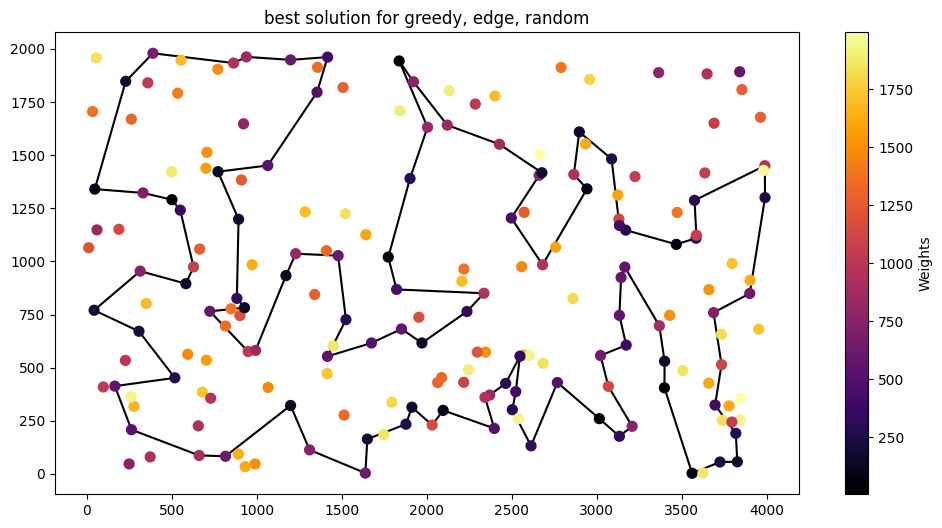

In [20]:
test_method(greedy, neighborhood2, True, 200, 'greedy, edge, random')

scores of greedy, random, node neighborhood:  70687 71633.565 72984
[117, 0, 46, 68, 139, 115, 193, 41, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 165, 40, 185, 106, 178, 3, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 82, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143]
average execution time: 0.10782262325286865


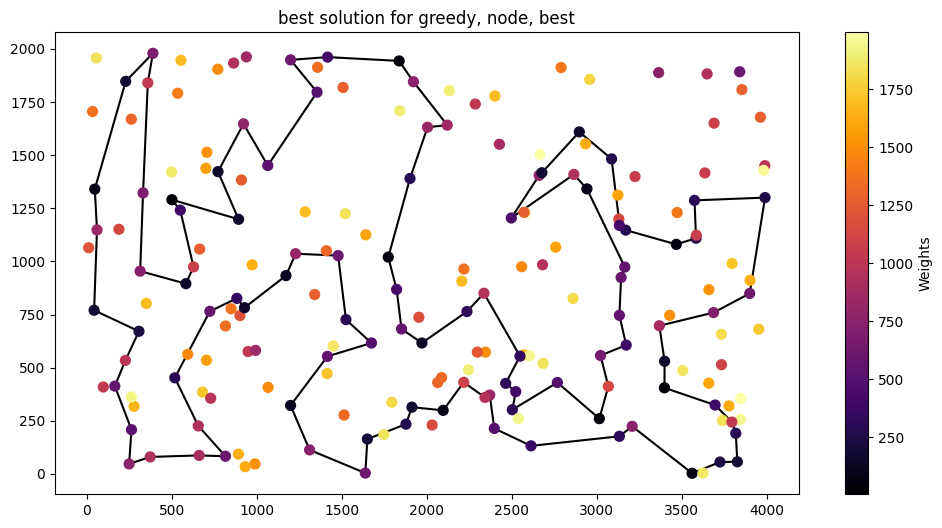

In [21]:
test_method(greedy, neighborhood1, False, 200, 'greedy, node, best')

scores of greedy, random, node neighborhood:  70571 71495.385 72570
[117, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 152, 97, 1, 101, 2, 82, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 3, 178, 106, 185, 40, 165, 90, 81, 196, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 108, 69, 159, 181, 42, 5, 41, 193, 115, 139, 68, 46, 0]
average execution time: 0.10101735949516297


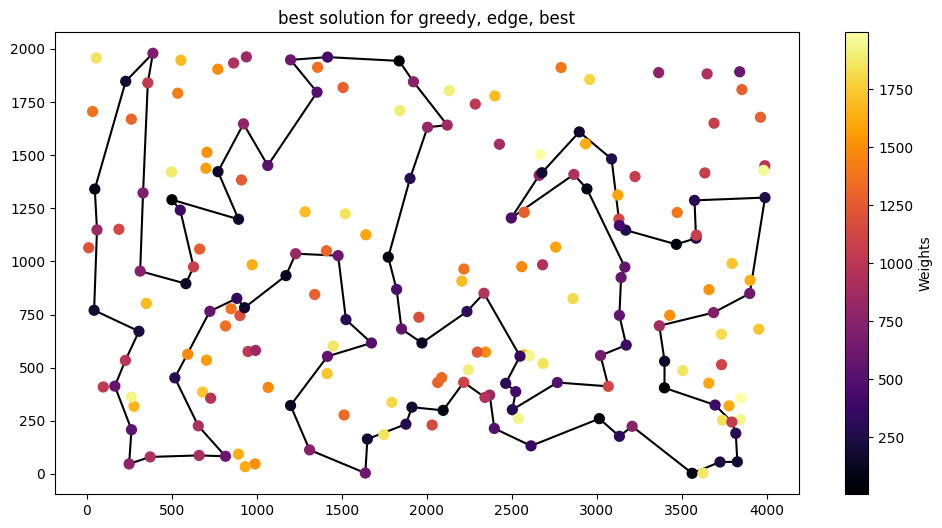

In [22]:
test_method(greedy, neighborhood2, False, 200, 'greedy, edge, best')

scores of greedy, random, node neighborhood:  79530 87929.795 98942
[145, np.int64(196), 81, np.int64(90), 164, 21, 144, 186, np.int64(23), 89, np.int64(183), 143, 0, 117, 68, 46, np.int64(115), 59, np.int64(118), np.int64(109), np.int64(51), 137, np.int64(148), np.int64(185), 40, np.int64(165), np.int64(138), np.int64(14), 3, 55, np.int64(57), np.int64(52), np.int64(106), 178, 49, 102, np.int64(62), np.int64(9), np.int64(120), np.int64(25), 78, 31, 113, 175, np.int64(171), np.int64(16), 44, 2, np.int64(1), 97, 94, np.int64(176), 80, 79, np.int64(63), np.int64(136), np.int64(53), np.int64(158), 86, np.int64(75), np.int64(101), np.int64(26), 100, 121, 133, 123, 127, 135, 180, 154, np.int64(70), 112, np.int64(177), np.int64(54), 184, 35, np.int64(131), 149, 43, np.int64(42), np.int64(5), 193, np.int64(159), np.int64(108), np.int64(18), np.int64(22), 146, np.int64(34), 160, np.int64(181), 41, np.int64(139), np.int64(116), np.int64(65), 47, 162, 151, np.int64(152), np.int64(129), 92]
avera

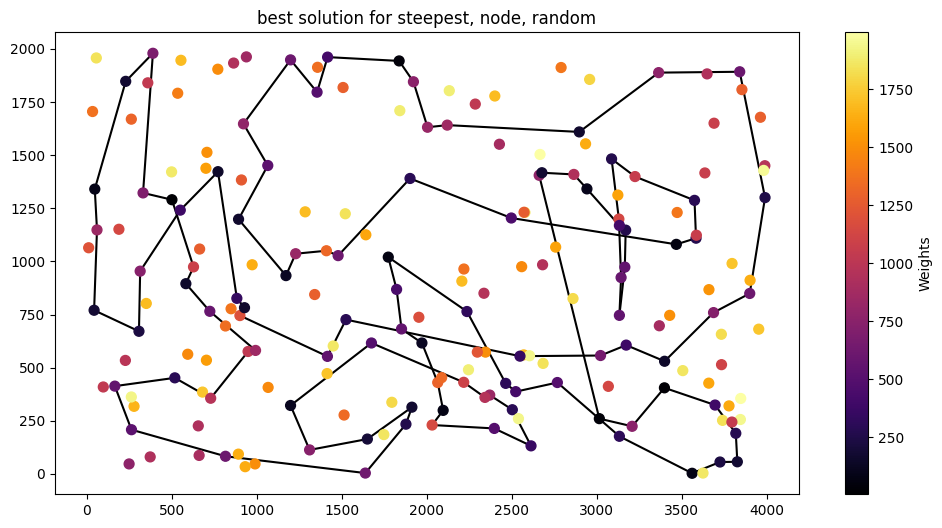

In [23]:
test_method(steepest, neighborhood1, True, 200, 'steepest, node, random')

scores of greedy, random, node neighborhood:  71642 73915.895 77633
[121, 53, np.int64(180), np.int64(154), 135, np.int64(70), np.int64(127), np.int64(123), np.int64(112), 4, 84, np.int64(35), np.int64(184), np.int64(10), 177, 54, np.int64(48), np.int64(160), 34, np.int64(146), 22, np.int64(18), 108, np.int64(69), 159, 193, np.int64(41), np.int64(181), np.int64(42), np.int64(43), 116, np.int64(65), np.int64(131), np.int64(149), 162, 151, np.int64(133), 79, np.int64(80), np.int64(176), np.int64(137), 51, 118, 59, 115, 139, np.int64(68), 46, np.int64(0), np.int64(117), np.int64(143), np.int64(183), np.int64(89), 186, 15, np.int64(144), 14, 138, np.int64(165), np.int64(185), np.int64(40), 90, np.int64(81), 196, np.int64(157), np.int64(56), np.int64(113), np.int64(175), np.int64(171), 16, 31, np.int64(179), 145, np.int64(78), 25, np.int64(44), np.int64(120), 75, 86, 26, np.int64(101), np.int64(1), np.int64(97), np.int64(152), np.int64(2), np.int64(129), 92, 57, np.int64(55), np.int64(52), 

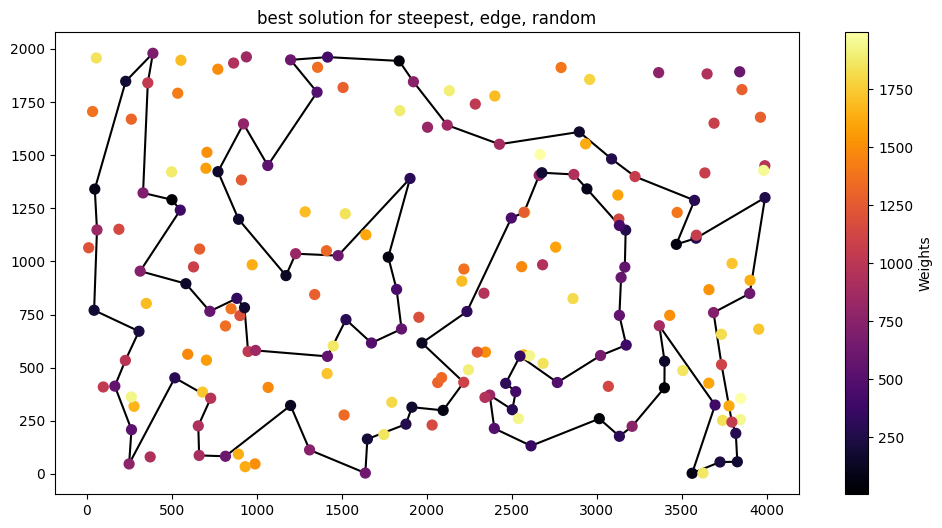

In [24]:
test_method(steepest, neighborhood2, True, 200, 'steepest, edge, random')

scores of greedy, random, node neighborhood:  70626 71615.87 72950
[0, 117, 93, 68, 46, 115, 139, 193, 41, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 165, 40, 185, 106, 178, 3, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 82, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143]
average execution time: 0.20208988428115846


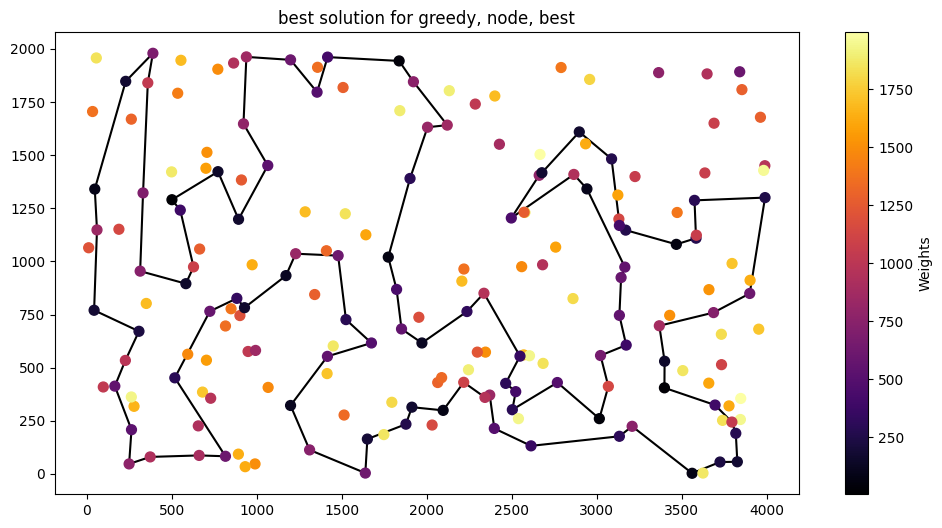

In [25]:
test_method(steepest, neighborhood1, False, 200, 'greedy, node, best')

scores of greedy, random, node neighborhood:  70510 71460.32 72614
[117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 152, 97, 1, 101, 2, 82, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 3, 178, 106, 185, 40, 165, 90, 81, 196, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 184, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 108, 69, 159, 181, 42, 5, 41, 193, 139, 115, 46, 68, 93]
average execution time: 0.20977096676826476


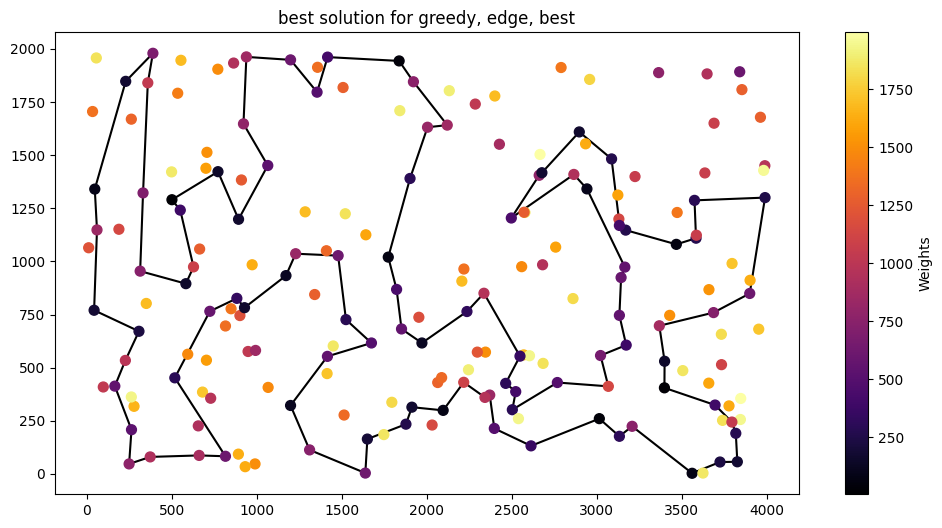

In [26]:
test_method(steepest, neighborhood2, False, 200, 'greedy, edge, best')